In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import math
import random

### Let's work through some basic plotting

482549 3015 24127


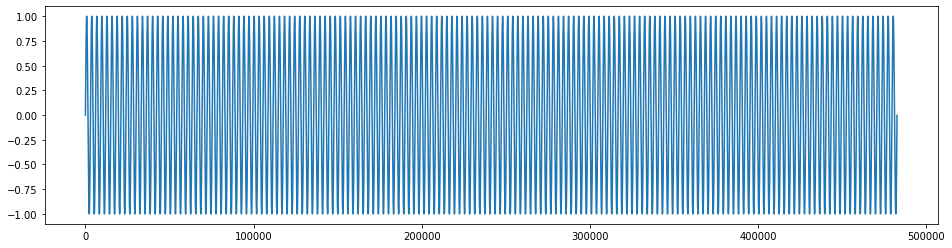

In [456]:
RAD = np.pi * 2
PERIODS = 8
INTERVALS = 20 # we can think of interval as seconds
TOTAL_PERIODS = PERIODS * INTERVALS
RESOLUTION = 3 # can be used to get additional steps in the graph / higher resolution
STEP_SIZE = 1 / (TOTAL_PERIODS * RESOLUTION)

rad_increments = np.arange(0, RAD * TOTAL_PERIODS, STEP_SIZE)

# make increments length rounded to nearest 100
#cut_off = rad_increments.shape[0] % 100
#rad_increments = rad_increments[:-cut_off]
TOTAL_RAD_INCREMENTS = rad_increments.shape[0]
RAD_INCREMENTS_PER_PERIOD = TOTAL_RAD_INCREMENTS // TOTAL_PERIODS
RAD_INCREMENTS_PER_INTERVAL = TOTAL_RAD_INCREMENTS // INTERVALS
print(TOTAL_RAD_INCREMENTS, RAD_INCREMENTS_PER_PERIOD, RAD_INCREMENTS_PER_INTERVAL)

signal = np.sin(rad_increments)

# plot over time
plt.figure(figsize=(16,4))
plt.plot(signal);

> Let's first plot the signal rotating around (0,0), with a red dot for the average of all the plot points

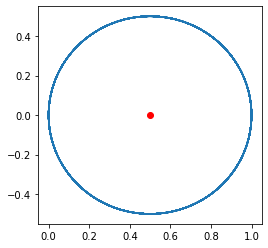

In [457]:
INTERVALS_PER_SAMPLE = 1

sample_size = RAD_INCREMENTS_PER_INTERVAL * INTERVALS_PER_SAMPLE

p_xs = np.sin(rad_increments[:sample_size]) * signal[:sample_size]
p_ys = np.cos(rad_increments[:sample_size]) * signal[:sample_size]
com_x, com_y = (p_xs.mean(), p_ys.mean())

plt.figure(figsize=(4,4))
plt.plot(p_xs, p_ys)
plt.plot(com_x, com_y, 'ro');


> now let's look at the signal plotted at a specific number of periods per cycle

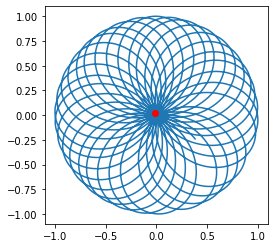

In [521]:
SAMPLE_PERIODS_PER_CYCLE = 11.34

def build_cycle_sample(periods_per_cycle:float, target_signal, intervals:float=INTERVALS, resolution:float=RESOLUTION):
    sample_size = periods_per_cycle * intervals * resolution
    sample_step_size = 1 / sample_size
    sample_rad_increments = np.arange(0, RAD * periods_per_cycle, sample_step_size)
    clip_size = sample_rad_increments.shape[0]

    q_xs = np.sin(sample_rad_increments) * target_signal[:clip_size]
    q_ys = np.cos(sample_rad_increments) * target_signal[:clip_size]
    q_com_x, q_com_y = (q_xs.mean(), q_ys.mean())
    
    return q_xs, q_ys, q_com_x, q_com_y

q_xs, q_ys, q_com_x, q_com_y = build_cycle_sample(SAMPLE_PERIODS_PER_CYCLE, signal)

plt.figure(figsize=(4,4))
plt.plot(q_xs, q_ys)
plt.plot(q_com_x, q_com_y, 'ro');


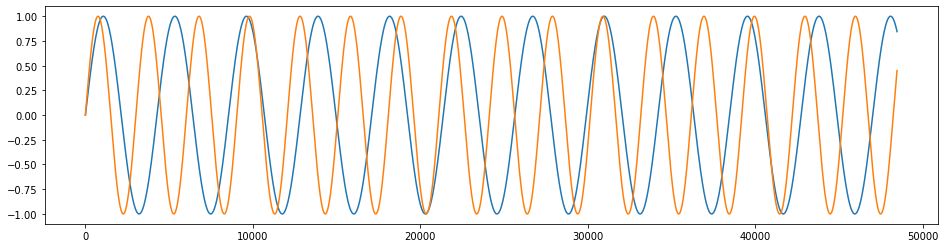

In [460]:
plt.figure(figsize=(16,4))
plt.plot(np.sin(sample_rad_increments));
plt.plot(signal[:clip_size]);

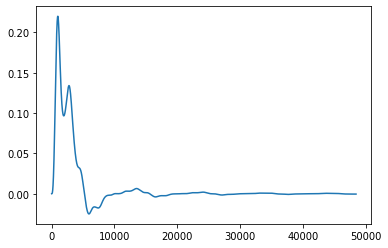

In [522]:
# Let's get the rolling average for the center point of this signal
def rolling_average(x):
    result = []
    for i in range(1, x.shape[0]):
        result.append(x[:i].mean())
    return np.array(result)

plt.plot(rolling_average(q_xs) * rolling_average(q_ys))

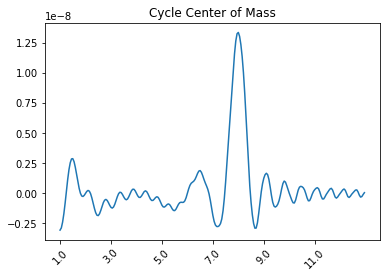

In [523]:
'''
Now, we will try and figure out which period is associated with our signal.
Let's step through the periods 1 -> 13 in increments of 0.05 and get the 
average of all vectors for that signal.
'''
coms = []
l = np.arange(1, 13, 0.05)
for x in l:
    _, _, com_x, comy = build_cycle_sample(x, signal)
    coms.append(com_x * com_y)

coms = np.array(coms)
plt.plot(coms)
tick_positions = range(0, len(l), 40)
tick_labels = [f'{l[xx]:.1f}' for xx in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45);
plt.title("Cycle Center of Mass");

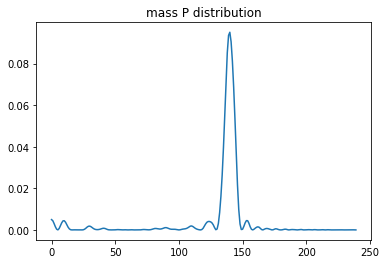

In [524]:
# now let's normalize and then convert to distribution
dist = coms**2/(coms**2).sum()
plt.plot(dist)
plt.title("mass P distribution");

In [525]:
# which period is associated most closely with our sampling.
l[np.argmax(dist)]

8.000000000000007

5.0


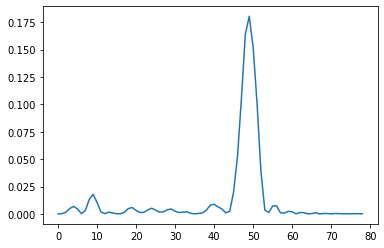

In [544]:
def almost_fourier_transform(target_signal:np.array, start:float, stop:float, step:float, intervals:float, resolution:float=RESOLUTION):
    coms = []
    steps = np.arange(start, stop, step)
    for s in steps:
        _, _, com_x, comy = build_cycle_sample(s, target_signal, intervals, resolution)
        coms.append(com_x * com_y)
    coms = np.array(coms)
    dist = coms**2/(coms**2).sum()
    return steps[np.argmax(dist)], steps, dist, coms


def build_signal(p:float, i:float, r:float=RESOLUTION):
    step_size = 1 / (p * i * r)
    rad_inc = np.arange(0, RAD * p * i, step_size)
    return np.sin(rad_inc)

new_interval = 10
new_period = 5
new_resolution = 3
new_signal = build_signal(new_period, new_interval)
p, s, d, c = almost_fourier_transform(new_signal, 0.1, 8, 0.1, new_interval)
print(p)
plt.plot(d);

## Rewriting and moving forward

Okay, now that I understand the concept roughly, let's rewrite some stuff and start again.

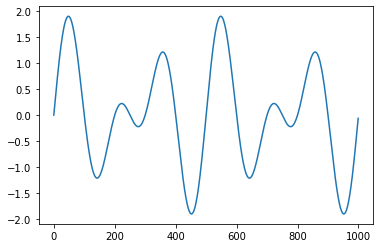

In [595]:
def build_signal(hz:float, seconds:float=2., resolution:int=1000):
    
    total_periods =  hz * seconds
    total_rad = math.pi * 2 * total_periods
    step_size = total_rad / resolution
    rad_inc = np.arange(0, total_rad, step_size)
    
    return np.sin(rad_inc)

def build_complex_signal(freqs:list, seconds:float=2., resolution:int=1000):
    x = np.zeros(resolution)
    for freq in freqs:
        x = x + build_signal(freq)
    return x

plt.plot(build_complex_signal([3, 2]))